In [2]:
!pip install pgmpy
!pip install networkx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 9.1 MB/s eta 0:00:00


<ipython-input-8-5e557214a797>:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax4.set_xticklabels(labels, rotation=45)


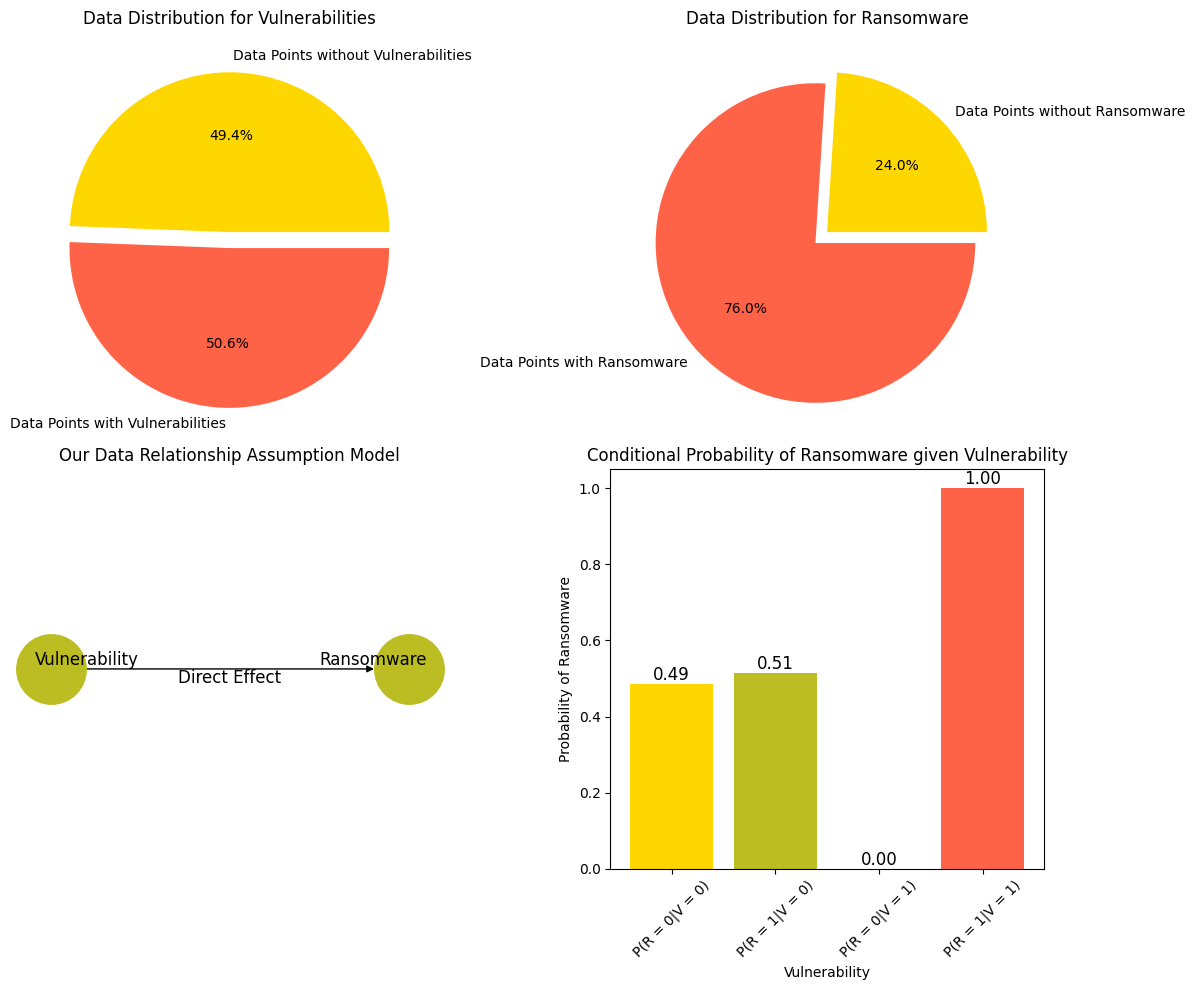

In [8]:
#Importing packages
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

num_samples = 500
prob = .5

# Let's Generate synthetic data for vulnerabilities (binary: 0 or 1)
vulnerabilities = np.random.choice([0, 1], num_samples)

ransomware = [1 if np.random.uniform(0, 1) < prob * (v + 1) else 0 for v in vulnerabilities]

data = pd.DataFrame({
'Vulnerability': vulnerabilities,
'Ransomware': ransomware
})

# Designing the Network
model = BayesianNetwork([('Vulnerability', 'Ransomware')])
model.fit(data,estimator=MaximumLikelihoodEstimator)

# Check model for early errors
assert model.check_model()

inference = VariableElimination(model)

# Calculating marginal probabilities
prob_vulnerability = inference.query(variables=['Vulnerability']).values
prob_ransomware = inference.query(variables=['Ransomware']).values

# Calculating conditional probabilities i.e. P(Ransomware | Vulnerability)
evidence_vulnerability = {'Vulnerability': 1}
prob_ransomware_with_vulnerability = inference.query(variables=['Ransomware'], evidence=evidence_vulnerability)

evidence_no_vulnerability = {'Vulnerability': 0}
prob_ransomware_without_vulnerability = inference.query(variables=['Ransomware'], evidence=evidence_no_vulnerability)


# Visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

# Subplot 1: Data Distribution of Instances with and without vulnerabilities
ax1.pie(
    prob_vulnerability,
    labels = ['Data Points without Vulnerabilities', 'Data Points with Vulnerabilities'],
    autopct = '%1.1f%%', colors = ['gold', 'tomato'],
    explode = (0.0, 0.1))
ax1.set_title('Data Distribution for Vulnerabilities')

# Subplot 2: Data Distribution of Instances with and without Ransomware
ax2.pie(
    prob_ransomware,
    labels = ['Data Points without Ransomware', 'Data Points with Ransomware'],
    autopct = '%1.1f%%', colors = ['gold', 'tomato'],
    explode = (0.0, 0.1))
ax2.set_title('Data Distribution for Ransomware')

# Subplot 3: NetworkX Showing assumed relationship between the variables
G = nx.DiGraph()

G.add_node('Vulnerability', pos=(-0.8, 0.0))
G.add_node('Ransomware', pos=(0.8, 0.0))
G.add_edge('Vulnerability', 'Ransomware', label='Direct Effect')

node_pos = nx.get_node_attributes(G, 'pos')
edge_labels = nx.get_edge_attributes(G, 'label')

pos = nx.planar_layout(G)
nx.draw_networkx_edge_labels(G, node_pos,
                             edge_labels = edge_labels,
                             verticalalignment = 'top',
                             font_size = 12, ax = ax3)
nx.draw_networkx_labels(G, node_pos,
                        verticalalignment = 'bottom',
                        font_size = 12, ax = ax3)
nx.draw(G, pos, with_labels = False, node_size = 2500, node_color = 'tab:olive', ax = ax3)
ax3.set_title('Our Data Relationship Assumption Model')

# Subplot 4: Bar chart for conditional probability of Ransomware given Vulnerability
values = [prob_ransomware_without_vulnerability.values[0],
     prob_ransomware_without_vulnerability.values[1],
     prob_ransomware_with_vulnerability.values[0],
     prob_ransomware_with_vulnerability.values[1]]
labels = ['P(R = 0|V = 0)', # P(No Ransomware Attack | No Vulnerabilites)
          'P(R = 1|V = 0)', # P(Ransomware Attack | No Vulnerabilites)
          'P(R = 0|V = 1)', # P(No Ransomware Attack | Vulnerabilites)
          'P(R = 1|V = 1)'] # P(Ransomware Attack | Vulnerabilites)
ax4.bar(labels, values, color = ['gold', 'tab:olive', 'lightcoral', 'tomato'])

for i, value in enumerate(values):
    ax4.annotate(f'{value:.2f}', (i, value), ha='center', va='bottom', fontsize=12)

ax4.set_xlabel('Vulnerability')
ax4.set_ylabel('Probability of Ransomware')
ax4.set_title('Conditional Probability of Ransomware given Vulnerability')
ax4.set_xticklabels(labels, rotation=45)

plt.tight_layout()
plt.show()

From: https://towardsdatascience.com/exploring-counterfactual-insights-from-correlation-to-causation-in-data-analysis-c3ee44d8e777


40% of instances do not receive the ‘treatment’: P(do(No Treatment)) = 0.4 , while 60% do: P(do(Treatment)) = 0.6.

When no treatment is applied, the distribution of vulnerabilities remains unaffected and can be derived from our initial data: P(Vulnerability = 0| do(No Treatment)) = 0.52, and P(Vulnerability = 1| do(no Treatment)) = 0.48

When treatment is applied, independent to the vulnerability data point at hand, 90% of the instances result in zero vulnerabilities: P(Vulnerability = 0| do(Treatment)) = 0.9, while 10% still have vulnerabilities: P(Vulnerability = 1 | do(Treatment)) = 0.1


We also have prior knowledge of the conditional probabilities for ransomware and vulnerabilities from our previous data, which we incorporate into our analysis:

P(Ransomware = 0 | Vulnerability = 0) = 0.80
P(Ransomware = 0 | Vulnerability = 1) = 0.56
P(Ransomware = 1| Vulnerability = 0) = 0.20
P(Ransomware = 1| Vulnerability = 1) = 0.44


Total Effect of the treatment:  -0.0912


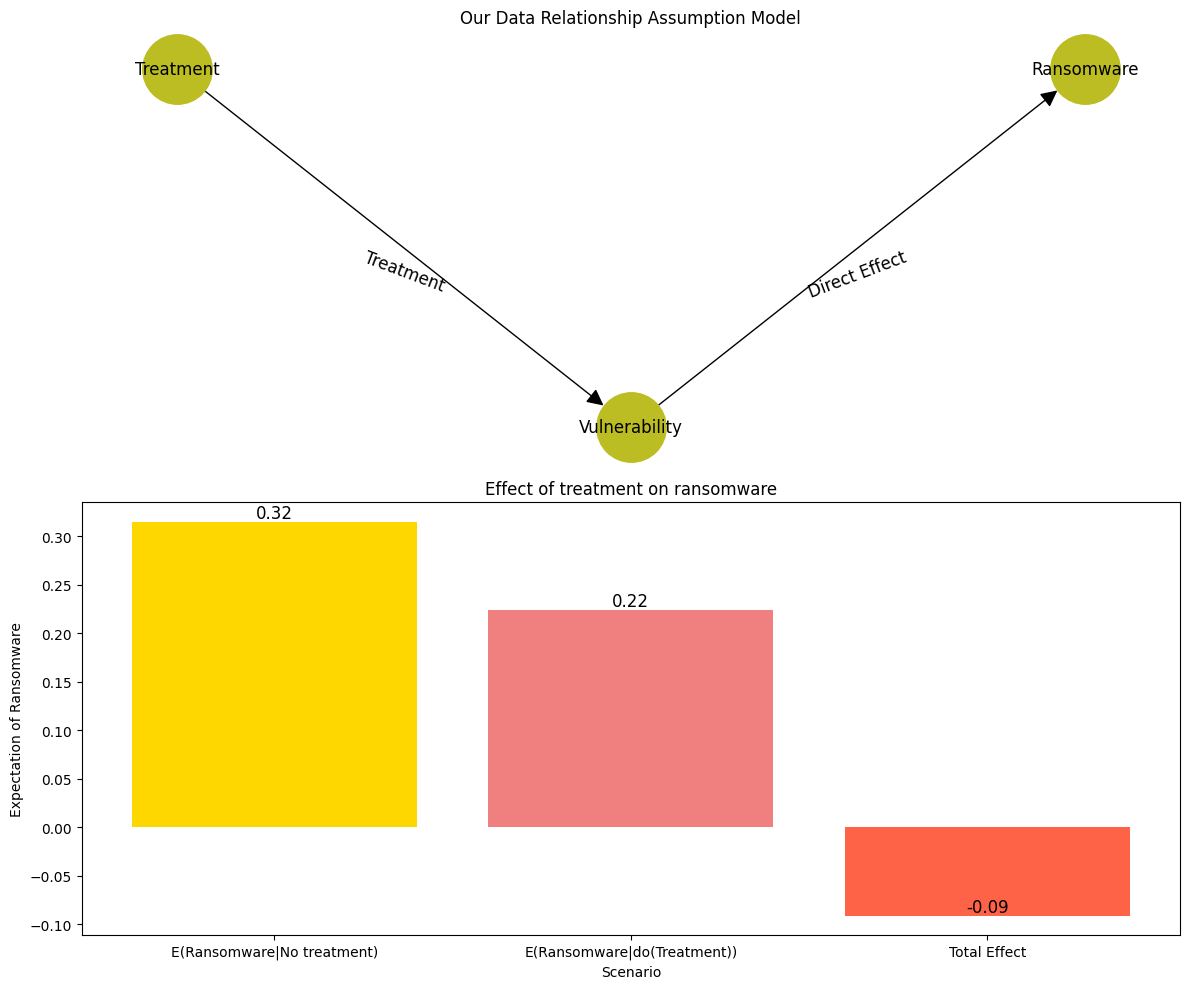

In [6]:
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
import matplotlib.pyplot as plt


# Define Conditional Probability Distributions (CPDs)
cpd_treatment = TabularCPD(variable='Treatment', variable_card=2, values=[[0.4], [0.6]])
cpd_vulnerability = TabularCPD(variable='Vulnerability', variable_card=2, values=[[0.52, 0.9], [0.48, 0.1]],
                            evidence=['Treatment'], evidence_card=[2])
cpd_ransomware = TabularCPD(variable='Ransomware', variable_card=2, values=[[0.80, 0.56], [0.20, 0.44]],
                            evidence=['Vulnerability'], evidence_card=[2])

# Create Network and add CPDs to the model
model = BayesianNetwork([('Treatment','Vulnerability'),('Vulnerability', 'Ransomware')])
model.add_cpds(cpd_treatment ,cpd_vulnerability, cpd_ransomware)


# Check model consistency
assert model.check_model()

inference = VariableElimination(model)

# Caluclating Total Effect of Treatment
evidence_treatment = {'Treatment': 1}
prob_treatment = inference.query(variables=['Ransomware'], evidence=evidence_treatment)


evidence_no_treatment = {'Treatment': 0}
prob_no_treatment = inference.query(variables=['Ransomware'], evidence=evidence_no_treatment)

total_effect = prob_treatment.values[1] - prob_no_treatment.values[1]
print('Total Effect of the treatment: ', total_effect)

# Creating Visualization
# 2 Subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))


# Subplot 1: NetworkX Showing treatment on the assumed relationship between the variables
G = nx.DiGraph()

G.add_nodes_from(['Treatment', 'Vulnerability', 'Ransomware'])
pos = {
    'Treatment': (0, 1),
    'Vulnerability': (1, 0),
    'Ransomware': (2, 1),
}

G.add_edge('Vulnerability', 'Ransomware', label='Direct Effect')
G.add_edge('Treatment', 'Vulnerability', label='Treatment')
edge_labels = nx.get_edge_attributes(G, 'label')


nx.draw_networkx_edge_labels(G, pos,
                             edge_labels = edge_labels,
                             verticalalignment = 'top',
                             font_size = 12, ax = ax1)

nx.draw(G, pos, with_labels = True,
        node_size=2500, node_color='tab:olive',
        arrowstyle="-|>,head_width=0.5,head_length=1", ax=ax1)

ax1.set_title('Our Data Relationship Assumption Model')


# Subplot 2: Bar chart for intervention of Ransomware given do(Treatment)

total_effect = prob_treatment.values[1] - prob_no_treatment.values[1]

values = [prob_no_treatment.values[1],
          prob_treatment.values[1],
          total_effect]

labels = ['E(Ransomware|No treatment)',
          'E(Ransomware|do(Treatment))',
          'Total Effect']
ax2.bar(
    labels,
    values,
    color = ['gold', 'lightcoral', 'tomato']
)

for i, value in enumerate(values):
    ax2.annotate(f'{value:.2f}', (i, value), ha='center', va='bottom', fontsize=12)

ax2.set_xlabel('Scenario')
ax2.set_ylabel('Expectation of Ransomware')
ax2.set_title('Effect of treatment on ransomware')
plt.savefig('treated_plots.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()